##In this notebook, I have implemented a hybrid model, comprising of an LSTM part and CNN part. Although the accuracy of this approach is the lowest but, it can be researched further and might yield better results.

##Step 1: Load the data and import necessary libraries

In [ ]:
!cp drive/My\ Drive/finaldata.csv /content

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import re
from PIL import Image
import requests
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense,Dropout,LSTM,Bidirectional,concatenate,Flatten,Embedding
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve
import seaborn as sn

In [ ]:
data = pd.read_csv('finaldata.csv')

tensorflow.org/tutorials/text/classify_text_with_bert

In [ ]:
data.head()

,Unnamed: 0,Product Name,Description,Image,Category
0,0,Alisha Solid Women's Cycling Shorts,key features alisha solid women s cycling shor...,"[""http://img5a.flixcart.com/image/short/u/4/a/...",Clothing
1,1,FabHomeDecor Fabric Double Sofa Bed,fabhomedecor fabric double sofa bed finish col...,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",Furniture
2,2,AW Bellies,key features aw bellies sandals wedges heel ca...,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",Footwear
3,3,Alisha Solid Women's Cycling Shorts,key features alisha solid women s cycling shor...,"[""http://img5a.flixcart.com/image/short/6/2/h/...",Clothing
4,6,Alisha Solid Women's Cycling Shorts,key features alisha solid women s cycling shor...,"[""http://img6a.flixcart.com/image/short/p/j/z/...",Clothing


In [ ]:
data.drop('Unnamed: 0',axis = 1,inplace = True)

##Step 2: Label Encode the given categories and 80:20 split into training and validation data

In [ ]:
le = LabelEncoder()
data['Category'] = le.fit_transform(data['Category'])

In [ ]:
trainx,testx,trainimg,testimg,trainy,testy = train_test_split(data['Description'],data['Image'],data['Category'],stratify = data['Category'],random_state = 20)

In [ ]:
data.isna().sum()

Product Name    0
Description     0
Image           3
Category        0
dtype: int64

In [ ]:
data.dropna(subset = ['Image'],inplace = True)

In [ ]:
trainimg.reset_index(inplace=True,drop = True)
testimg.reset_index(inplace=True,drop = True)

##Step 3: Load the training and testing images using the given URL. If the image is not found, store the index to remove the entries from data

PIL is used to load the received raw image file. The image is then scaled down to (128,128,3) adn divided by 255 to normalize to 0-1

In [ ]:
train_images = []
test_images = []

In [ ]:
notfound = []

In [ ]:
for i in tqdm(range(len(trainimg))):
  try:
    url = re.sub('["[\]]','',trainimg[i]).split(',')[0]
    im = Image.open(requests.get(url, stream=True).raw).convert('RGB').resize((128,128))
    img = np.asarray(im).astype('float32')
    img = img/255
    train_images.append(img)
  except:
    notfound.append(i)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (90608000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [ ]:
len(notfound)

1216

In [ ]:
notfound2 = []

In [ ]:
for i in tqdm(range(len(testimg))):
  try:
    url = re.sub('["[\]]','',testimg[i]).split(',')[0]
    im = Image.open(requests.get(url, stream=True).raw).convert('RGB').resize((128,128))
    img = np.asarray(im).astype('float32')
    img = img/255
    test_images.append(img)
  except:
    notfound2.append(i)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [ ]:
len(notfound2)

406

##Step 4: Save the loaded images to numpy file and send it to Google Drive

In [ ]:
np.save('trainimages',np.array(train_images))
np.save('testimages',np.array(test_images))

In [ ]:
np.save('traindelidx',notfound)
np.save('testdelidx',notfound2)

In [ ]:
!zip -r approach3files.zip trainimages.npy testimages.npy traindelidx.npy testdelidx.npy

  adding: trainimages.npy (deflated 82%)
  adding: testimages.npy (deflated 82%)
  adding: traindelidx.npy (deflated 79%)
  adding: testdelidx.npy (deflated 77%)


In [ ]:
!cp approach3files.zip drive/My\ Drive

##Switch to GPU runtime and load the image files into memory from Google Drive

In [ ]:
!cp drive/My\ Drive/approach3files.zip /content

In [ ]:
!unzip -q approach3files.zip

In [ ]:
train_images = np.load('trainimages.npy')
test_images = np.load('testimages.npy')

In [ ]:
train_del_idx = np.load('traindelidx.npy')
test_del_idx = np.load('testdelidx.npy')

###Remove the data for which images were not found

In [ ]:
trainx = trainx.reset_index(drop = True)
testx = testx.reset_index(drop = True)
trainy = trainy.reset_index(drop = True)
testy = testy.reset_index(drop = True)

In [ ]:
trainx.drop(index = train_del_idx,inplace = True)
testx.drop(index = test_del_idx,inplace=True)

In [ ]:
trainy.drop(index = train_del_idx,inplace = True)
testy.drop(index = test_del_idx,inplace=True)

###Use mobilenet to encode images

In [ ]:
mobnet = MobileNetV2(input_shape=(128,128,3),include_top=False,weights='imagenet')

###Create 2 separate models, one for text input and the other for Image Input

###Concatenate the two models and add Dense Layers and a final inference layer.

In [ ]:
imgmodel = Sequential()
imgmodel.add(mobnet)
imgmodel.add(Flatten())

textmodel = Sequential()
textmodel.add(Embedding(6000,50,input_length=100))
textmodel.add(Bidirectional(LSTM(64,return_sequences=True)))
textmodel.add(Bidirectional(LSTM(128,return_sequences=False)))

concat = concatenate([imgmodel.output,textmodel.output])
final_model = Dense(512,activation = 'relu')(concat)
final_model = Dense(256,activation = 'relu')(final_model)
final_model = Dense(22,activation = 'softmax')(final_model)
final_model = Model([imgmodel.input,textmodel.input],final_model)

Compiling the final model

In [ ]:
final_model.compile('adamax','categorical_crossentropy',['accuracy'])

###Tokenizing the input sentences and pad the resulting sequences to convert sentences into vectors

In [ ]:
tok = Tokenizer(num_words = 6000)
tok.fit_on_texts(trainx)
train_sent = tok.texts_to_sequences(trainx)
train_sent = pad_sequences(train_sent,maxlen = 100)
test_sent = tok.texts_to_sequences(testx)
test_sent = pad_sequences(test_sent,maxlen = 100)

One Hot Encode the target labels

In [ ]:
train_labels = to_categorical(trainy)
test_labels = to_categorical(testy)

####Fitting the model on given dataset

In [ ]:
hist = final_model.fit([train_images,train_sent],train_labels,validation_data = ([test_images,test_sent],test_labels),epochs = 10, batch_size = 32)

Epoch 1/10
422/422 [==============================] - 72s 149ms/step - loss: 1.2488 - accuracy: 0.7088 - val_loss: 1.4571 - val_accuracy: 0.6925
Epoch 2/10
422/422 [==============================] - 61s 145ms/step - loss: 0.3466 - accuracy: 0.9010 - val_loss: 1.7386 - val_accuracy: 0.6934
Epoch 3/10
422/422 [==============================] - 61s 145ms/step - loss: 0.2043 - accuracy: 0.9411 - val_loss: 1.1485 - val_accuracy: 0.7735
Epoch 4/10
422/422 [==============================] - 61s 145ms/step - loss: 0.1382 - accuracy: 0.9565 - val_loss: 1.1715 - val_accuracy: 0.7891
Epoch 5/10
422/422 [==============================] - 61s 145ms/step - loss: 0.0869 - accuracy: 0.9730 - val_loss: 1.0102 - val_accuracy: 0.8129
Epoch 6/10
422/422 [==============================] - 61s 144ms/step - loss: 0.0741 - accuracy: 0.9773 - val_loss: 0.8156 - val_accuracy: 0.8501
Epoch 7/10
422/422 [==============================] - 61s 145ms/step - loss: 0.0479 - accuracy: 0.9833 - val_loss: 1.0417 - val_ac

In [ ]:
preds = final_model.predict([test_images,test_sent])

In [ ]:
preds = preds.argmax(axis = 1)

In [ ]:
n = data['Category'].unique().max()+1
label_names = []
for i in range(n):
  label_names.append(le.inverse_transform(np.array(i).reshape(-1,1))[0])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


####Evatuating the model using classification report

The model has poor performance, with 70% Macro Average

In [ ]:
print(classification_report(test_labels.argmax(axis = 1),preds,target_names=label_names))

                                   precision    recall  f1-score   support

                       Automotive       0.75      0.90      0.82       254
                        Baby Care       0.73      0.71      0.72       115
            Bags, Wallets & Belts       0.82      0.64      0.72        66
         Beauty and Personal Care       0.77      0.82      0.79       178
            Cameras & Accessories       1.00      0.48      0.65        21
                         Clothing       0.99      0.96      0.97      1232
                        Computers       0.51      0.80      0.63       145
                          Eyewear       1.00      0.92      0.96        12
                         Footwear       0.94      0.96      0.95       309
                        Furniture       0.97      0.67      0.79        45
Health & Personal Care Appliances       0.50      0.09      0.15        11
       Home Decor & Festive Needs       0.84      0.73      0.78       233
                  Home F

In [ ]:
print(classification_report(train_labels.argmax(axis = 1),final_model.predict([train_images,train_sent]).argmax(axis = 1),target_names=label_names))

                                   precision    recall  f1-score   support

                       Automotive       0.89      0.99      0.94       760
                        Baby Care       0.95      0.93      0.94       336
            Bags, Wallets & Belts       0.98      0.92      0.95       199
         Beauty and Personal Care       0.96      0.98      0.97       534
            Cameras & Accessories       1.00      0.81      0.90        64
                         Clothing       1.00      0.99      0.99      3715
                        Computers       0.82      0.98      0.89       435
                          Eyewear       1.00      1.00      1.00        35
                         Footwear       0.99      0.98      0.99       928
                        Furniture       1.00      0.85      0.92       137
Health & Personal Care Appliances       1.00      0.91      0.95        32
       Home Decor & Festive Needs       0.96      0.95      0.95       699
                  Home F

####Plotting confusion matrix for training and validation data

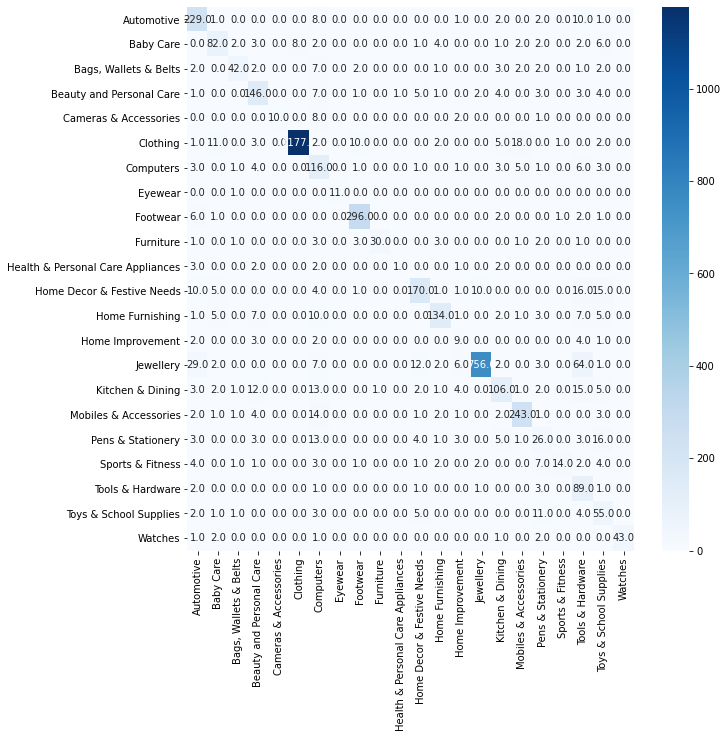

In [ ]:
cm = confusion_matrix(test_labels.argmax(axis = 1),preds)
plt.figure(figsize=(10,10))
sn.heatmap(cm,cmap = 'Blues',annot = True,fmt = '.1f',xticklabels = label_names,yticklabels=label_names)

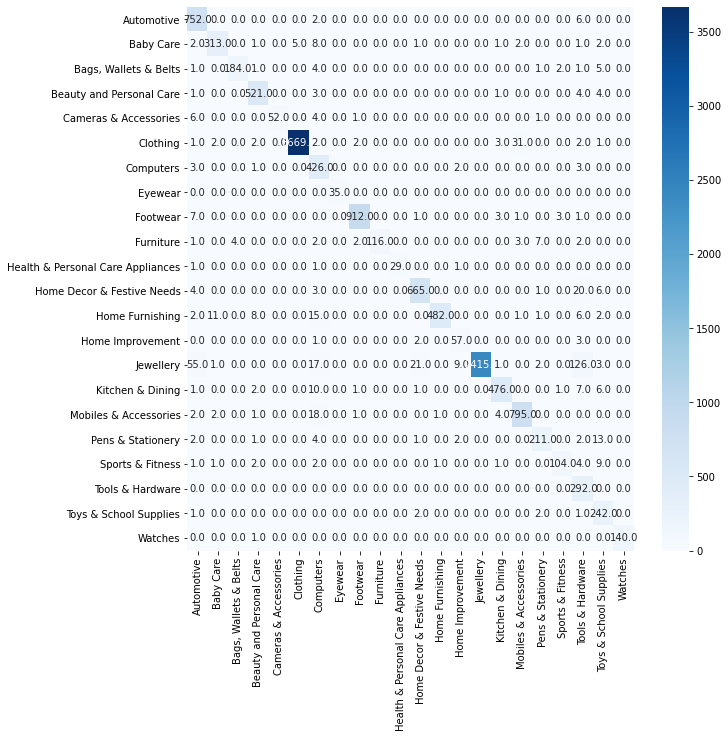

In [ ]:
cm = confusion_matrix(train_labels.argmax(axis = 1),final_model.predict([train_images,train_sent]).argmax(axis = 1))
plt.figure(figsize=(10,10))
sn.heatmap(cm,cmap = 'Blues',annot = True,fmt = '.1f',xticklabels = label_names,yticklabels=label_names)

####Plotting loss and accuracy curves for the model

The validation loss does not decay well as compared to training loss

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)

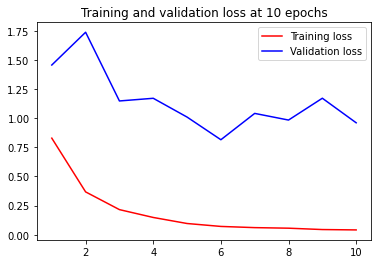

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss at 10 epochs')
plt.legend()

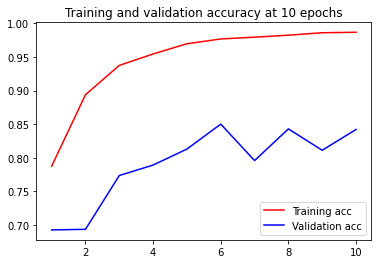

In [ ]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy at 10 epochs')
plt.legend()

Saving the model in Google Drive for future use

In [ ]:
final_model.save('hybrid')

INFO:tensorflow:Assets written to: hybrid/assets


INFO:tensorflow:Assets written to: hybrid/assets


In [ ]:
!cp -r hybrid drive/My\ Drive

In [ ]:
!pip freeze ->req3.txt

###Results and Conclusion
The model has a unique approach but fails to achieve high accuracy, most probably due to lack of data. Researching further into this approach can be beneficial

###Future Scope

1. Use more data
2. Experiment with a different model architecture
3. Use Word Embeddings (GLoVe, etc.)
4. Hyperparameter Tuning